In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# データ読み込み

In [2]:
train = pd.read_csv('../input/spaceship-titanic/train.csv')
test = pd.read_csv('../input/spaceship-titanic/test.csv')
submit = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')

# EDA

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [5]:
submit.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [6]:
!pip install sweetviz
import sweetviz as sv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 48.8 MB/s eta 0:00:00


In [7]:
# # train のEDA
# my_report_train = sv.analyze(train)
# my_report_train.show_html("sweetviz_report_Spaceship_train_V1.html")

# # train と test の関係
# my_report_trainVStest = sv.compare([train, "Train"], [test, "Test"], "Transported")
# my_report_trainVStest.show_html("sweetviz_report_Spaceship_trainVStest_V1.html")

# 前処理 
1. NaNがあるかないか
2. Cabin分裂(deck(encoding),side(encoding),num(そのまま))
3. サービス系(RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)の欠損値をLightGBMで予測して補完
4. HomePlanetとDestination合併
3. 家族(nameから)
4. 同室人数
5. カテゴリ変数の欠損値補完
6. カテゴリ変数の変換 (HomePlanet・Destination・CryoSleep・VIP・Transportedを数値変換)
7. 同室確認
8. サービス料合計
9. 不要な列を削除
10. clipping
11. binning

In [8]:
df = pd.concat([train.drop(["Transported"], axis=1), test], ignore_index=True)

In [9]:
#　NaNがあるかないか
df_colmns_list = df.drop(["PassengerId"], axis=1).columns

for column in df_colmns_list:
    df["Nan_"+ column] = np.where(df[column].isna(), 1, 0)

In [10]:
# Cabin分裂(deck(encoding),side(encoding),num(そのまま))

CabinAry_df = df["Cabin"].str.split("/", expand=True)

df["Cabin_Deck"] = CabinAry_df[0]
df["Cabin_Num"] = CabinAry_df[1]
df["Cabin_Side"] = CabinAry_df[2]

# Cabin_Num がoblect型になっていてlightgbmに突っ込めないからfloat型にする
df["Cabin_Num"] = df["Cabin_Num"].astype(float)

In [11]:
import lightgbm as lgbm
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter('ignore')

In [12]:
# 欠損値学習のためのLabelEncording

NaN_cat_columns_df = ["HomePlanet","CryoSleep","Cabin_Deck"]
NaN_drop_list = ["PassengerId","Cabin",'Nan_HomePlanet', 'Nan_CryoSleep', 'Nan_Cabin', 'Nan_Destination',
                 'Nan_Age', 'Nan_VIP', 'Nan_RoomService', 'Nan_FoodCourt','Nan_ShoppingMall',
                 'Nan_Spa', 'Nan_VRDeck', 'Nan_Name',"Cabin_Side","Destination","VIP","Name"]
df_NaN = df.drop(NaN_drop_list, axis=1) # 欠損値学習に使わないカラムを落とす

for c in NaN_cat_columns_df:
    le = LabelEncoder()
    le.fit(df_NaN[c])
    df_NaN[c] = le.transform(df_NaN[c])

In [13]:
# サービス系(RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)の欠損値をLightGBMで予測して補完

Service_list = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

for column_service in Service_list:
    NonExist_NaN_df = df_NaN[df_NaN[column_service].notna()]  # columnにNaNがないdf
    Only_NaN_df = df_NaN[df_NaN[column_service].isna()]  # columnがNaNのみのdf

    NaN_train_X_row = NonExist_NaN_df.drop([column_service], axis=1)
    NaN_train_y_row = NonExist_NaN_df[column_service]
    NaN_test_X = Only_NaN_df.drop([column_service], axis=1)
    NaN_test_y = Only_NaN_df[column_service]

    NaN_train_X,NaN_valid_X, NaN_train_y, NaN_valid_y = train_test_split(NaN_train_X_row, NaN_train_y_row, test_size=0.25, random_state=42)

    lgb_NaN_train = lgbm.Dataset(NaN_train_X,NaN_train_y)
    lgb_NaN_valid = lgbm.Dataset(NaN_valid_X,NaN_valid_y)

    params = {
                    "objective": "regression", 
                    'metric': 'rmse',
                    "learning_rate": .1,
                    "reg_lambda": .1,
                    "reg_alpha": 0,
                    "max_depth": 5, 
                    "n_estimators": 10000, 
                    "colsample_bytree": .5, 
                    "min_child_samples": 10,
                    "subsample_freq": 3,
                    "subsample": .9,
                    "random_state": 1,
                    'verbose': -1
                }

    gbm = lgbm.train(params,
                     train_set=lgb_NaN_train,
                     valid_sets=[lgb_NaN_valid],
                     callbacks=[early_stopping(stopping_rounds=100,
                                    verbose=False),
                               log_evaluation(0)]
                     )

    NaN_valid_y_pred = gbm.predict(NaN_valid_X)
    NaN_score = mean_squared_error(y_true=NaN_valid_y, y_pred=NaN_valid_y_pred, squared=False)
    print(f'{column_service}:RMSE={NaN_score}\n')

    # feature importanceを表示
    importance = pd.DataFrame(gbm.feature_importance(importance_type='gain'), index=NaN_train_X.columns, columns=['importance'])
    importance = importance.sort_values('importance', ascending=False)
    display(importance)
    print("-" * 50)

    NaN_test_y_pred = gbm.predict(NaN_test_X)
    NaN_test_y = pd.Series(data=NaN_test_y_pred, index=NaN_test_y.index)
    
    df[column_service].fillna(NaN_test_y, inplace=True)

RoomService:RMSE=596.9059976426911



,importance
ShoppingMall,2.377750e+09
FoodCourt,1.480773e+09
Spa,1.474482e+09
HomePlanet,1.442062e+09
VRDeck,1.252732e+09
CryoSleep,1.223125e+09
Age,1.007205e+09
Cabin_Num,9.679669e+08
Cabin_Deck,5.951792e+08


--------------------------------------------------
FoodCourt:RMSE=1278.8690831817303



,importance
VRDeck,1.699674e+10
HomePlanet,9.988744e+09
Cabin_Deck,7.233991e+09
Spa,6.907900e+09
Cabin_Num,4.334519e+09
ShoppingMall,3.420084e+09
Age,2.731422e+09
RoomService,2.599131e+09
CryoSleep,1.633594e+09


--------------------------------------------------
ShoppingMall:RMSE=658.895631074394



,importance
RoomService,1.017830e+09
VRDeck,9.694241e+08
Spa,9.213617e+08
FoodCourt,9.135434e+08
HomePlanet,6.332942e+08
CryoSleep,6.140815e+08
Age,5.714734e+08
Cabin_Num,4.815289e+08
Cabin_Deck,3.736637e+08


--------------------------------------------------
Spa:RMSE=974.4089196703671



,importance
FoodCourt,6.876536e+09
VRDeck,5.291890e+09
HomePlanet,3.606993e+09
Cabin_Deck,3.383555e+09
Age,3.086155e+09
Cabin_Num,2.147600e+09
RoomService,1.479557e+09
ShoppingMall,1.167144e+09
CryoSleep,5.615519e+08


--------------------------------------------------
VRDeck:RMSE=975.6148241513913



,importance
FoodCourt,9.909232e+09
Spa,4.566580e+09
HomePlanet,3.546268e+09
Cabin_Deck,2.763924e+09
ShoppingMall,1.985691e+09
RoomService,1.695580e+09
Age,1.614680e+09
Cabin_Num,1.476423e+09
CryoSleep,7.169997e+08


--------------------------------------------------


In [14]:
df.isna().sum()

PassengerId           0
HomePlanet          288
CryoSleep           310
Cabin               299
Destination         274
Age                 270
VIP                 296
RoomService           0
FoodCourt             0
ShoppingMall          0
Spa                   0
VRDeck                0
Name                294
Nan_HomePlanet        0
Nan_CryoSleep         0
Nan_Cabin             0
Nan_Destination       0
Nan_Age               0
Nan_VIP               0
Nan_RoomService       0
Nan_FoodCourt         0
Nan_ShoppingMall      0
Nan_Spa               0
Nan_VRDeck            0
Nan_Name              0
Cabin_Deck          299
Cabin_Num           299
Cabin_Side          299
dtype: int64

In [15]:
# HomePlanetとDestination合併

df["Home×Dest"] = df["HomePlanet"] + df["Destination"]

In [16]:
# 家族(nameから)

df["Family"] = df["Name"].str.split(" ", expand=True)[1]

In [17]:
# 同室人数

cabin_group = df.groupby("Cabin")
df_Sameroom = pd.DataFrame({"SameRoomNum":cabin_group.size()})
df = pd.merge(df,df_Sameroom,how="left",on="Cabin")

In [18]:
# 同室確認

df["SameRoomBinary"] = np.where((df["SameRoomNum"]==1) | (df["SameRoomNum"].isna()), 0, 1)

In [19]:
#  サービス料合計

df["Service_Sum"] = df[Service_list].sum(axis=1)

In [20]:
# カテゴリ変数の変換 (HomePlanet,Destination,CryoSleep,VIP,Cabin_Deck,Cabin_Side,Home×Dest,Family,Transported を数値変換)

from sklearn.preprocessing import LabelEncoder

cat_columns_df = ["HomePlanet","Destination","CryoSleep","VIP","Cabin_Deck","Cabin_Side","Home×Dest","Family"]

for c in cat_columns_df:
    le = LabelEncoder()
    le.fit(df[c])
    df[c] = le.transform(df[c])

In [21]:
# 前処理後の train のEDA
my_report_train = sv.analyze(train)
my_report_train.show_html("sweetviz_report_Spaceship_train_V2.html")

# 前処理後の train と test の関係
my_report_trainVStest = sv.compare([train, "Train"], [test, "Test"], "Transported")
my_report_trainVStest.show_html("sweetviz_report_Spaceship_trainVStest_V2.html")

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report_Spaceship_train_V2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report_Spaceship_trainVStest_V2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [22]:
df.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Nan_HomePlanet', 'Nan_CryoSleep', 'Nan_Cabin',
       'Nan_Destination', 'Nan_Age', 'Nan_VIP', 'Nan_RoomService',
       'Nan_FoodCourt', 'Nan_ShoppingMall', 'Nan_Spa', 'Nan_VRDeck',
       'Nan_Name', 'Cabin_Deck', 'Cabin_Num', 'Cabin_Side', 'Home×Dest',
       'Family', 'SameRoomNum', 'SameRoomBinary', 'Service_Sum'],
      dtype='object')

In [23]:
# 不要な列を削除
drop_list = ['PassengerId', 'Cabin', 'Name', "VIP", "Destination", "HomePlanet", "SameRoomNum"]

df.drop(drop_list, axis=1, inplace=True)

In [24]:
df

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Nan_HomePlanet,Nan_CryoSleep,Nan_Cabin,...,Nan_Spa,Nan_VRDeck,Nan_Name,Cabin_Deck,Cabin_Num,Cabin_Side,Home×Dest,Family,SameRoomBinary,Service_Sum
0,0,39.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,1,0.0,0,5,1551,0,0.0
1,0,24.0,109.0,9.0,25.0,549.0,44.0,0,0,0,...,0,0,0,5,0.0,1,2,2289,0,736.0
2,0,58.0,43.0,3576.0,0.0,6715.0,49.0,0,0,0,...,0,0,0,0,0.0,1,5,2153,1,10383.0
3,0,33.0,0.0,1283.0,371.0,3329.0,193.0,0,0,0,...,0,0,0,0,0.0,1,5,2153,1,5176.0
4,0,16.0,303.0,70.0,151.0,565.0,2.0,0,0,0,...,0,0,0,5,1.0,1,2,1924,0,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,1,34.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,6,1496.0,1,2,1657,0,0.0
12966,0,42.0,0.0,847.0,17.0,10.0,144.0,0,0,1,...,0,0,0,8,NaN,2,2,1937,0,1018.0
12967,1,NaN,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,3,296.0,0,6,1707,0,0.0
12968,0,NaN,0.0,2680.0,0.0,0.0,523.0,0,0,0,...,0,0,0,3,297.0,0,9,496,0,3203.0


In [25]:
# clipping

In [26]:
# binning

# 学習

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, log_loss

In [28]:
train_X = df.iloc[:train.shape[0],]
train_y = train["Transported"].astype(int)
test = df.iloc[train.shape[0]:,:]

In [29]:
class LightGBMCV:
    def __init__(self, fold, params=None):
        if params is None:
            self.params = {
                "objective": "binary", 
                "learning_rate": .1,
                "reg_lambda": .1,
                "reg_alpha": 0,
                "max_depth": 5, 
                "n_estimators": 10000, 
                "colsample_bytree": .5, 
                "min_child_samples": 10,
                "subsample_freq": 3,
                "subsample": .9,
                "importance_type": "gain", 
                "random_state": 1
            }
        else:
            self.params = params
        self.fold = fold
    
    @property
    def models(self):
        return self._models
    
    @property
    def pred_array(self):
        return self._pred_array
    
    def fit(self, X, y, early_stopping, score_func, **kwargs):
        self._feature_name = X.columns
        X, y = X.values, y.values
        self._models = []
        self._pred_array = np.zeros(len(y), dtype=np.float32)
            
        cv = self.fold.split(X, y)
        for i, (idx_train, idx_valid) in enumerate(cv):
            X_train, y_train = X[idx_train], y[idx_train]
            X_valid, y_valid = X[idx_valid], y[idx_valid]
            
            model = lgbm.LGBMModel(**self.params)
            model.fit(
                X_train,
                y_train,
                eval_set=[(X_valid, y_valid)],
                callbacks=[early_stopping, log_evaluation(period=0, show_stdv=False)]
            )
            self._models.append(model)
            y_pred = model.predict(X_valid, **kwargs)
            self._pred_array[idx_valid] = y_pred
            if score_func in [accuracy_score, f1_score]:
                score = score_func(y_valid, np.where(y_pred >= 0.5, 1, 0), **kwargs)
            else:
                score = score_func(y_valid, y_pred, **kwargs)
            print(f" - fold{i + 1} - {score: .4f}")
        
        if score_func in [accuracy_score, f1_score]:
            total_score = score_func(y, np.rint(self._pred_array), **kwargs)
        else:
            total_score = score_func(y, self._pred_array, **kwargs)
        print(f": {total_score: .4f}")
        
    def predict(self, test):
        test = test.values
        pred = np.array([model.predict(test) for model in self._models])
        pred = np.mean(pred, axis=0)
        return pred
    
    @property
    def df_feature_importance(self):
        return self._df_feature_importance
        
    def visualize_importance(self, top_num=10):
        
        fig, ax = plt.subplots(1, 1, figsize=(max(8, 1.2*top_num), 20))
        
        self._df_feature_importance = pd.DataFrame()
        for idx, clf  in enumerate(self._models):
            _df = pd.DataFrame()
            _df["feature_importance"] = clf.feature_importances_
            _df["feature_name"] = self._feature_name
            _df["fold"] = idx + 1
            self._df_feature_importance = pd.concat([self._df_feature_importance, _df])

        order = self._df_feature_importance.groupby("feature_name")["feature_importance"].sum()\
                                .sort_values(ascending=False).index[:top_num]

        sns.boxenplot(
            x="feature_importance", 
            y="feature_name", 
            data=self._df_feature_importance, 
            order=order, ax=ax
        )
        ax.grid()
        
        plt.show()

# fit

In [30]:
fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
model = LightGBMCV(fold=fold)

In [31]:
%%time
model.fit(
    train_X, 
    train_y, 
    early_stopping=early_stopping(100, verbose=False),
    score_func=accuracy_score
)

 - fold1 -  0.8212
 - fold2 -  0.8005
 - fold3 -  0.8097
 - fold4 -  0.8049
 - fold5 -  0.8147
:  0.8102
CPU times: user 7.97 s, sys: 139 ms, total: 8.11 s
Wall time: 2.05 s


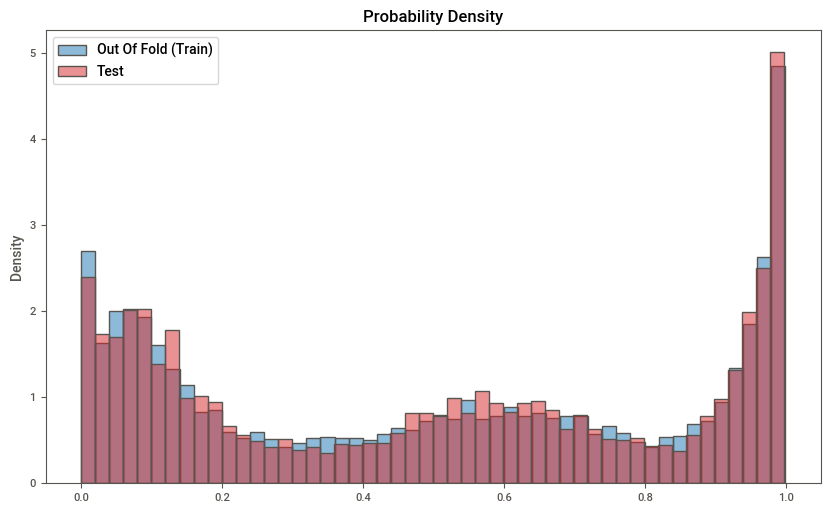

In [32]:
predict_prob = model.predict(test)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(x=model.pred_array, bins=50, alpha=0.5, ax=ax, stat="density", label="Out Of Fold (Train)", color="tab:blue")
sns.histplot(x=predict_prob, bins=50, alpha=0.5, ax=ax, stat="density", label="Test", color="tab:red")

ax.set_title("Probability Density")
ax.legend()
plt.show()

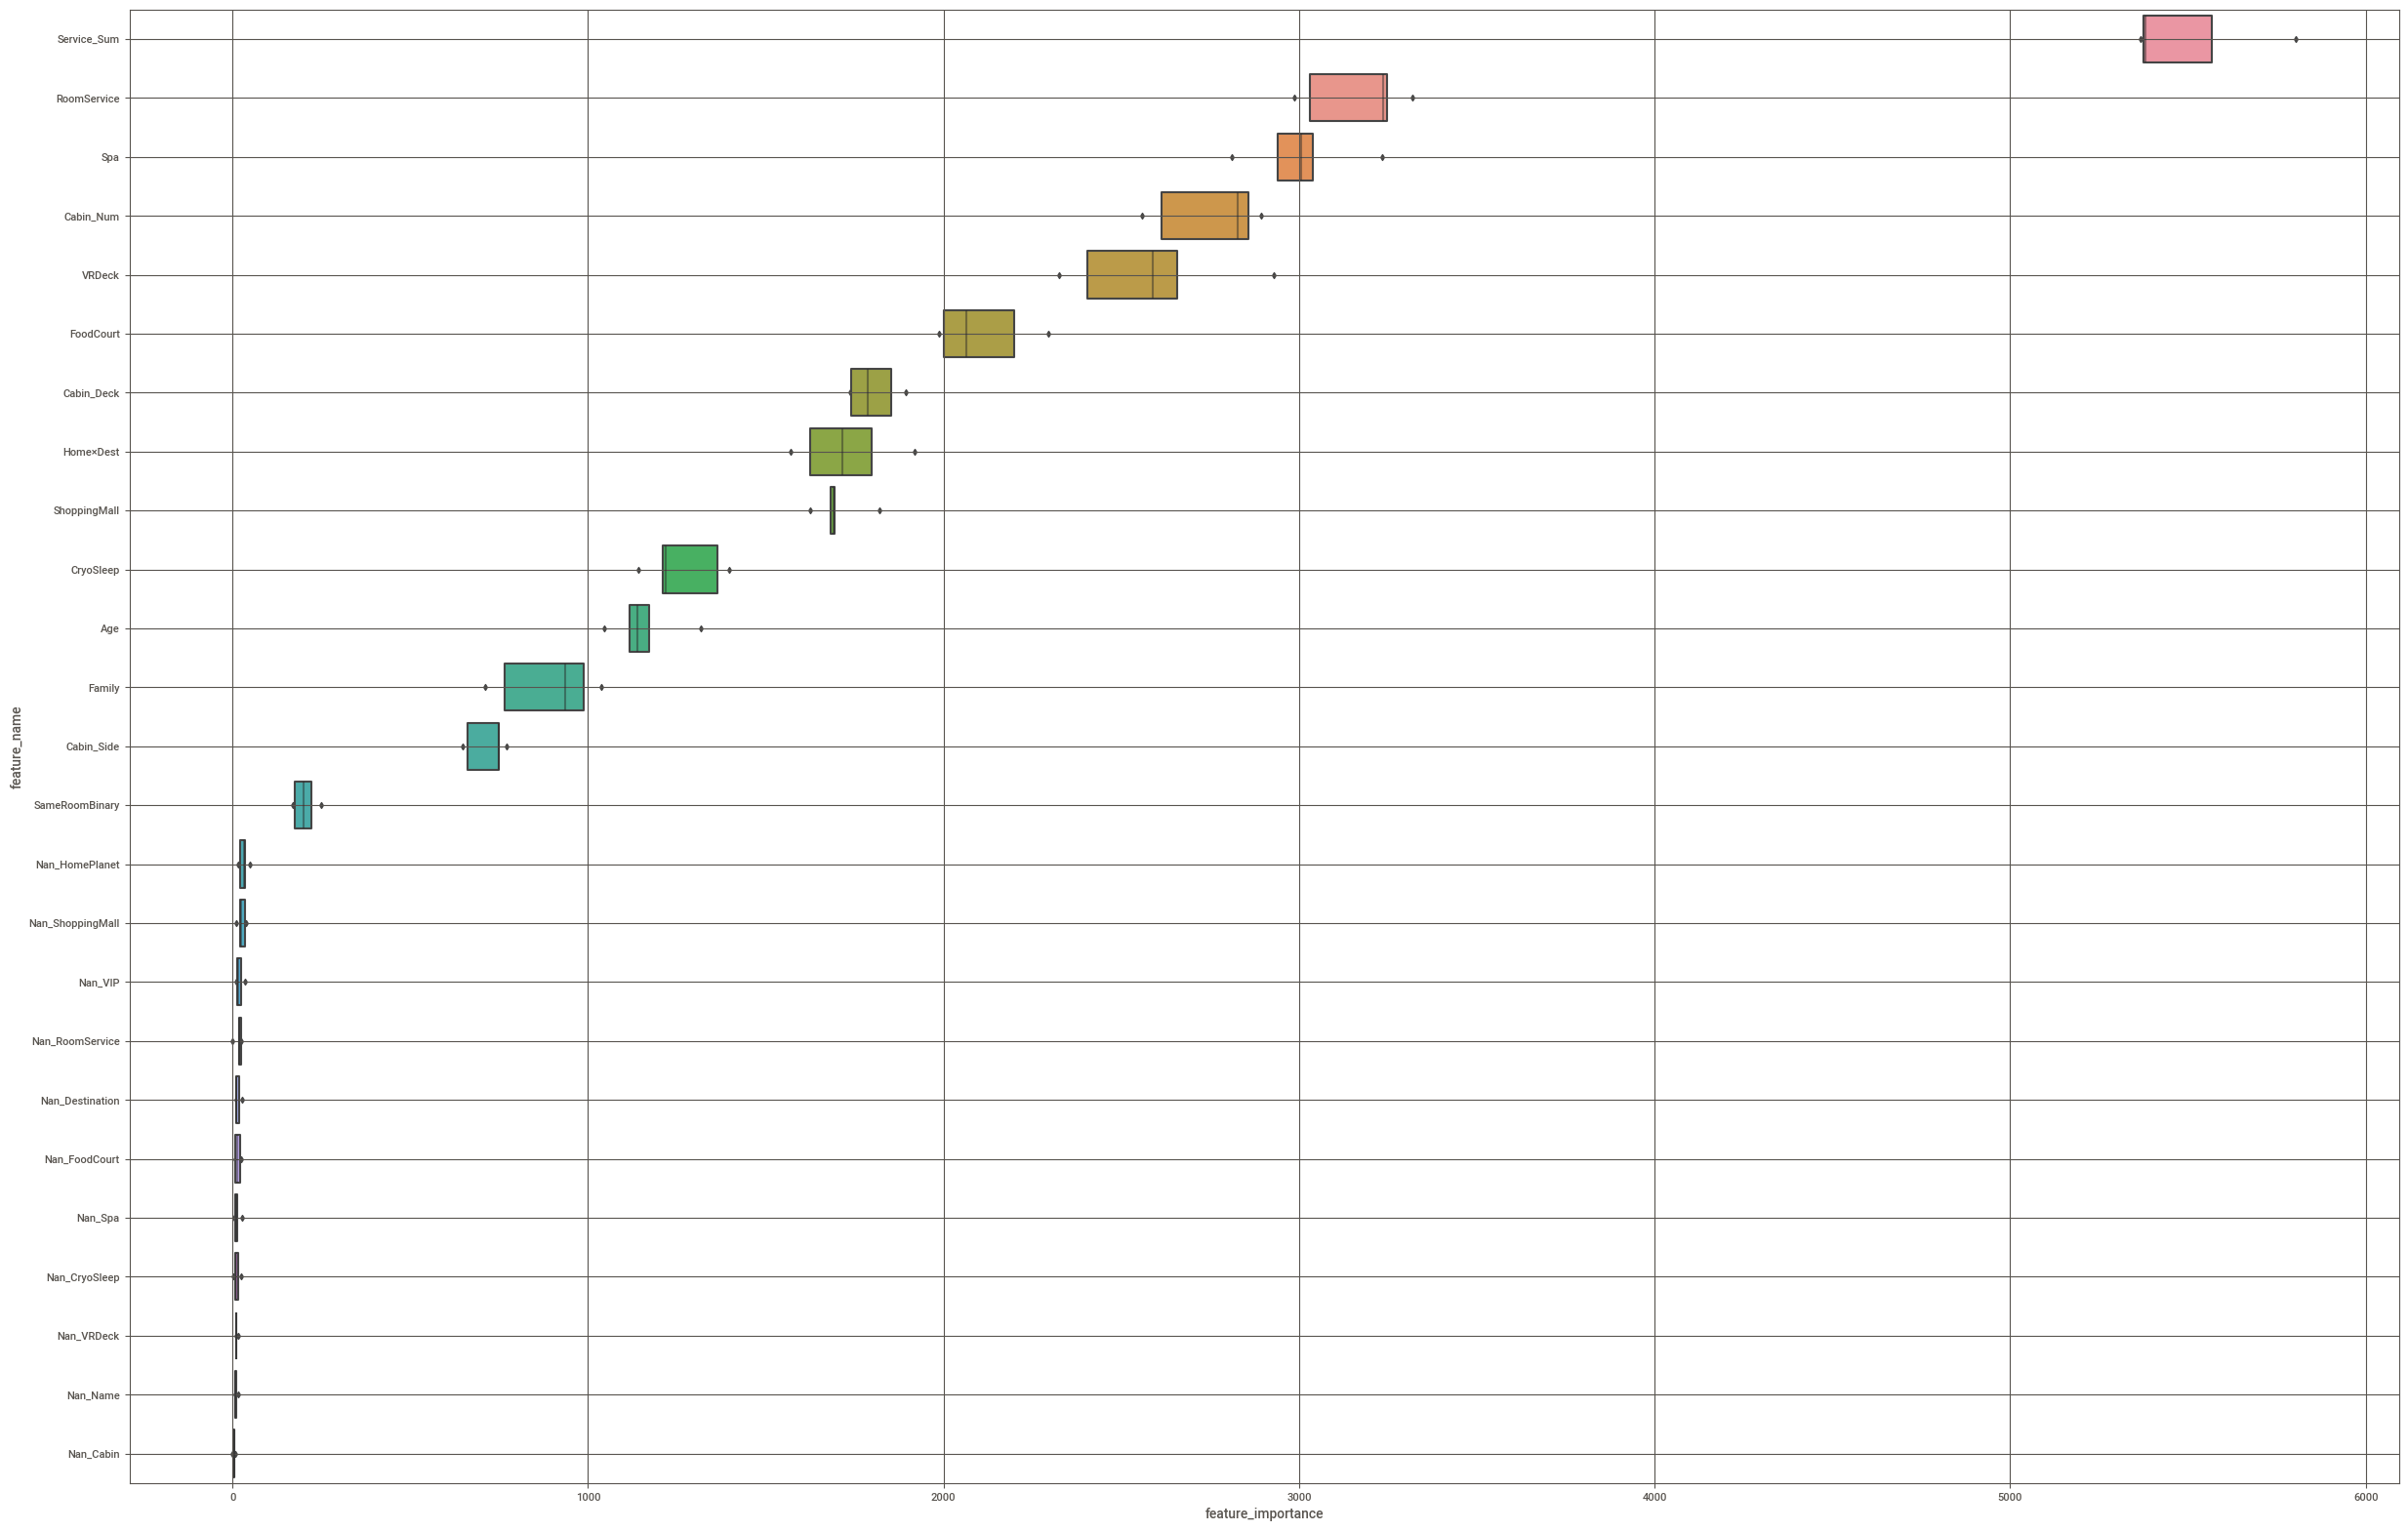

In [33]:
model.visualize_importance(top_num=25)

In [34]:
predict_prob

array([0.65180789, 0.01798574, 0.98474345, ..., 0.94212644, 0.81363217,
       0.64050613])

In [35]:
# spaceship_tiatanic.competition_submit(
#     submit.assign(Transported=np.where(predict_prob >= 0.5, True, False)),
#     message="cv; StratifiedKfold(5) features; add CabinCount DestinationFromDepature AgeByHomePlanetMean AgeByHomePlanetStd LuxuryBilledAmount LuxuryBilledCount, without VIP from Baseline",
#     file_name="7th_sub",
#     path="submission"
# )

In [36]:
sub = submit.assign(Transported=np.where(predict_prob >= 0.5, True, False))

sub.to_csv("spaceship_StratifiedKFold_5-fold_CV_Yuiki's_Model_Service_fullNaN.csv", index=False)

# 課題
1. trainとtestをdfでまとめて特徴量を作る
2. for分を減らして実行速度上げる
3. 